In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from random import randrange

In [2]:
import keras
import sklearn
print(keras.__version__)
print(sklearn.__version__)

2.6.0
0.24.2


In [3]:
#Read in the data
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_col.csv', index_col='CASEID')


In [4]:
data.head()

,COL_STEROID,COL_MECH_BOWEL_PREP,COL_ORAL_ANTIBIOTIC,COL_CHEMO,COL_INDICATION,COL_ICD9_INDICATION,COL_EMERGENT,COL_ICD9_EMERGENT,COL_APPROACH,COL_ANASTOMOTIC,SEX,PRNCPTX,CPT,WORKRVU,INOUT,TRANST,AGE,OPERYR,ANESTHES,SURGSPEC,ELECTSURG,HEIGHT,WEIGHT,DIABETES,SMOKE,DYSPNEA,FNSTATUS2,VENTILAT,HXCOPD,ASCITES,HXCHF,HYPERMED,RENAFAIL,DIALYSIS,DISCANCR,WNDINF,STEROID,WTLOSS,BLEEDDIS,TRANSFUS,PRSEPIS,PRSODM,PRBUN,PRCREAT,PRWBC,PRHCT,PRPLATE,EMERGNCY,WNDCLAS,ASACLAS,OPTIME,HTOODAY,SSSIPATOS,DSSIPATOS,OSSIPATOS,PNAPATOS,VENTPATOS,UTIPATOS,SEPSISPATOS,SEPSHOCKPATOS,COL_ICD10_INDICATION,COL_ICD10_EMERGENT,BMI,RACE
CASEID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6551967,0,2,0,0,3,451,6,155,0,0,2,6,4,3,0,1,64.0,5,1,1,2,1.8542,97.975872,2,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,139.0,8.4034,0.8032,7.1,38.0,190.0,0,1,2,121.0,0.0,0,0,0,0,0,0,0,0,445,123,28.497449,5
6552344,0,1,1,0,8,451,6,155,0,0,1,8,5,2,0,1,44.0,5,1,1,2,1.6256,83.914520,1,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,139.0,14.0000,0.8600,11.0,43.4,373.0,0,1,1,64.0,0.0,0,0,0,0,0,0,0,0,445,123,31.754826,6
6552431,0,2,2,0,2,451,6,155,0,0,1,7,6,5,0,1,30.0,5,1,1,2,1.6764,81.646560,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,138.0,3.0000,0.6000,4.7,37.7,309.0,0,2,1,99.0,0.0,0,0,0,0,0,0,0,0,445,123,29.052438,6
6552941,2,0,2,0,5,451,6,155,0,0,1,6,4,3,0,1,45.0,5,1,1,2,1.4986,47.627160,1,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,141.0,13.0000,0.5700,6.7,37.2,453.0,0,1,1,77.0,0.0,0,0,0,0,0,0,0,0,445,123,21.207195,6
6552982,0,0,0,0,3,451,6,155,0,1,1,6,4,3,0,1,50.0,5,1,1,2,1.6256,68.945984,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,138.0,11.0000,0.7300,7.3,29.7,432.0,0,1,1,134.0,0.0,0,0,0,0,0,0,0,0,445,123,26.090451,5


In [5]:
data.reset_index(inplace=True)
data.drop('CASEID', axis=1, inplace=True)

In [6]:
#define outcome "y" and predictors "X"
y = data['COL_ANASTOMOTIC']
X = data.drop(['COL_ANASTOMOTIC'], axis=1)

In [7]:
#generate 5 folds of cross-validation, with 5 train/test sets, export to csv
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
fold_no=0
for train_index, test_index in skf.split(data, y):
    train = data.loc[train_index,:]
    test = data.loc[test_index,:]
    train_filename = 'train' + str(fold_no) + '.csv'
    test_filename = 'test' + str(fold_no) + '.csv' 
    train.to_csv('splits/' + train_filename, index=False)
    test.to_csv('splits/' + test_filename, index=False) 
    fold_no += 1

In [8]:
#read the csv's back into a dictionary, naming them train or test 1-5
d = {}
for x in range(0,5):
    d['train{}'.format(x)] = pd.read_csv('splits/train{}.csv'.format(x), low_memory=False)
    d['test{}'.format(x)] = pd.read_csv('splits/test{}.csv'.format(x), low_memory=False)

In [9]:
#create a list of training data for X and y
dX_train = []
dy_train = []
for x in d:
    if 'train' in x:
        dX_train.append(d[x].drop(columns=['COL_ANASTOMOTIC'], axis=1))
        dy_train.append(d[x]['COL_ANASTOMOTIC'])

In [10]:
#create a list of test data for X and y
dX_test = []
dy_test = []
for x in d:
    if 'test' in x:
        dX_test.append(d[x].drop(columns=['COL_ANASTOMOTIC'], axis=1))
        dy_test.append(d[x]['COL_ANASTOMOTIC'])

rfpreds = []
xgbpreds = []
model = RandomForestClassifier(n_estimators=1250, min_samples_split=2, min_samples_leaf=8, max_features='auto', max_depth=20, bootstrap=True)
model2 = XGBClassifier(n_estimators=50, subsample=0.6, min_child_weight=10, max_depth=6, learning_rate=0.1, colsample_bytree=0.8)
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model.fit(X, y)
    model2.fit(X, y)
    rfpreds.append(model.predict_proba(X_test))
    xgbpreds.append(model2.predict_proba(X_test))

%store rfpreds
%store xgbpreds

for x in range(0,5):
    print(roc_auc_score(dy_test[x], rfpreds[x][:,1]))
    

for x in range(0,5):
    print(roc_auc_score(dy_test[x], xgbpreds[x][:,1]))

In [11]:
#define keras model with 2 layers, 1000 nodes, followed by batch norm and dropout
from tensorflow import keras
input_shape = [X.shape[1]]
model4 = keras.models.Sequential()
model4.add(keras.layers.Flatten(input_shape=input_shape))
model4.add(keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(keras.layers.Dense(1000))
    model4.add(keras.layers.BatchNormalization())
    model4.add(keras.layers.Dropout(0.8))
    model4.add(keras.layers.Activation("relu"))
model4.add(keras.layers.Dense(1, activation="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=3e-4)

metrics = [keras.metrics.Recall(name='Sensitivity'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.AUC(name='auc'), keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.00001,
    restore_best_weights=True,)

In [12]:
#split each training set into train/val, preserving 60/20/20 ratio, and fit the model
annpreds = []
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
    model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping])
    annpreds.append(model4.predict(X_test))

Epoch 1/200
229/229 [==============================] - 5s 15ms/step - loss: 0.2442 - Sensitivity: 0.0433 - tn: 109461.0000 - auc: 0.5131 - prc: 0.0368 - val_loss: 0.2100 - val_Sensitivity: 0.0662 - val_tn: 37459.0000 - val_auc: 0.6560 - val_prc: 0.0874
Epoch 2/200
229/229 [==============================] - 3s 11ms/step - loss: 0.1893 - Sensitivity: 0.0246 - tn: 112227.0000 - auc: 0.5447 - prc: 0.0466 - val_loss: 0.2058 - val_Sensitivity: 0.1002 - val_tn: 37329.0000 - val_auc: 0.6584 - val_prc: 0.0891
Epoch 3/200
229/229 [==============================] - 3s 12ms/step - loss: 0.1740 - Sensitivity: 0.0182 - tn: 112477.0000 - auc: 0.5610 - prc: 0.0489 - val_loss: 0.2124 - val_Sensitivity: 0.1033 - val_tn: 37270.0000 - val_auc: 0.6588 - val_prc: 0.0888
Epoch 4/200
229/229 [==============================] - 3s 12ms/step - loss: 0.1630 - Sensitivity: 0.0131 - tn: 112611.0000 - auc: 0.5869 - prc: 0.0534 - val_loss: 0.2109 - val_Sensitivity: 0.1057 - val_tn: 37264.0000 - val_auc: 0.6556 - val_

In [13]:
#calculate auroc for each of the 5 folds
ann_score = []
for x in range(0,5):
    ann_score.append(roc_auc_score(dy_test[x], annpreds[x]))

In [14]:
ann_score

[0.6799775889526353,
 0.6981062743118449,
 0.7158145366150336,
 0.7079689529757069,
 0.7306139953349061]

In [15]:
#find the mean auroc and 95% CI
ann_mean = np.mean(ann_score)
ann_confidence = st.t.interval(0.95, len(ann_score)-1, loc=ann_mean, scale=st.sem(ann_score))

print(round(ann_mean,3), '('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')')

0.706 (0.683-0.73)


model.fit(dX_train[0], dy_train[0])
def rf_feat_importance(model, X):
    return pd.DataFrame({'cols':X.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(model, X)
fi[:10]
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:20]);

model2.fit(dX_train[0], dy_train[0])
fi = rf_feat_importance(model2, X)
plot_fi(fi[:20]);

In [16]:
#train the logistic regression model, max_iter set to max due to large dataset size, no validation set needed for LR (no early stopping)
lrpreds = []
model3 = LogisticRegression()
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model3.fit(X, y)
    lrpreds.append(model3.predict_proba(X_test))
%store lrpreds

/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

Stored 'lrpreds' (list)


/home/kchen/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
#score the LR model on 5 folds
lr_score = []
for x in range(0,5):
    lr_score.append(roc_auc_score(dy_test[x], lrpreds[x][:,1]))

In [18]:
#find the mean and 95% CI
lr_mean = np.mean(lr_score)
lr_confidence = st.t.interval(0.95, len(lr_score)-1, loc=lr_mean, scale=st.sem(lr_score))

print('Logistic Regression:', round(lr_mean,3), '('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')')

Logistic Regression: 0.631 (0.618-0.644)


In [19]:
#write results to txt file
ann_prc = []
for x in range(0,5):
    ann_prc.append(average_precision_score(dy_test[x], annpreds[x]))

ann_prc_mean = np.mean(ann_prc)
ann_prc_confidence = st.t.interval(0.95, len(ann_prc)-1, loc=ann_prc_mean, scale=st.sem(ann_prc))

print('Neural Network:', round(ann_prc_mean,3), '('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')
lr_prc = []
for x in range(0,5):
    lr_prc.append(average_precision_score(dy_test[x], lrpreds[x][:,1]))

lr_prc_mean = np.mean(lr_prc)
lr_prc_confidence = st.t.interval(0.95, len(lr_prc)-1, loc=lr_prc_mean, scale=st.sem(lr_prc))

print('Logistic Regression:', round(lr_prc_mean,3), '('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')')
with open('col_results.txt', 'w') as f:
    f.write('Logistic Regression: '+str(round(lr_mean,3))+' ('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_mean,3))+' ('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')\n')
    f.write('AUPRC\n')
    f.write('Logistic Regression: '+str(round(lr_prc_mean,3))+' ('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_prc_mean,3))+' ('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

Neural Network: 0.119 (0.101-0.136)
Logistic Regression: 0.056 (0.051-0.06)


In [20]:
#generate fpr and tpr to create ROC curves
col_ann_tpr = []
col_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    col_ann_tpr.append(tpr)
    col_ann_fpr.append(fpr)

#sklearn's roc_curve function created fpr/tpr of different lengths (different number of thresholds)
#averaging different length lists results in truncated ROC curves
#randomly delete values to make each list the same length
for x in range(0,5):
    diff = len(col_ann_tpr[x]) - 1000
    for _ in range(diff):
        ind = randrange(len(col_ann_tpr[x]))
        col_ann_tpr[x] = np.delete(col_ann_tpr[x],ind)
for x in range(0,5):
    diff = len(col_ann_fpr[x]) - 1000
    for _ in range(diff):
        ind = randrange(len(col_ann_fpr[x]))
        col_ann_fpr[x] = np.delete(col_ann_fpr[x],ind)

#find the mean tpr's and fpr's
mean_col_ann_tpr = [np.mean(k) for k in zip(*col_ann_tpr)]
mean_col_ann_fpr = [np.mean(k) for k in zip(*col_ann_fpr)]

#save the means to use in the curves notebook
%store mean_col_ann_tpr
%store mean_col_ann_fpr

#same process for LR
col_lr_tpr = []
col_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    col_lr_tpr.append(tpr)
    col_lr_fpr.append(fpr)
for x in range(0,5):
    diff = len(col_lr_tpr[x]) - 1000
    for _ in range(diff):
        ind = randrange(len(col_lr_tpr[x]))
        col_lr_tpr[x] = np.delete(col_lr_tpr[x],ind)

for x in range(0,5):
    diff = len(col_lr_fpr[x]) - 1000
    for _ in range(diff):
        ind = randrange(len(col_lr_fpr[x]))
        col_lr_fpr[x] = np.delete(col_lr_fpr[x],ind)

mean_col_lr_tpr = [np.mean(k) for k in zip(*col_lr_tpr)]
mean_col_lr_fpr = [np.mean(k) for k in zip(*col_lr_fpr)]
%store mean_col_lr_tpr
%store mean_col_lr_fpr

#same process for precision-recall curves
col_lr_rec = []
col_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    col_lr_rec.append(rec)
    col_lr_prec.append(prec)

for x in range(0,5):
    diff = len(col_lr_rec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(col_lr_rec[x]))
        col_lr_rec[x] = np.delete(col_lr_rec[x],ind)

for x in range(0,5):
    diff = len(col_lr_prec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(col_lr_prec[x]))
        col_lr_prec[x] = np.delete(col_lr_prec[x],ind)

mean_col_lr_rec = [np.mean(k) for k in zip(*col_lr_rec)]

mean_col_lr_prec = [np.mean(k) for k in zip(*col_lr_prec)]
%store mean_col_lr_rec
%store mean_col_lr_prec
col_ann_rec = []
col_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    col_ann_rec.append(rec)
    col_ann_prec.append(prec)

for x in range(0,5):
    diff = len(col_ann_rec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(col_ann_rec[x]))
        col_ann_rec[x] = np.delete(col_ann_rec[x],ind)

for x in range(0,5):
    diff = len(col_ann_prec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(col_ann_prec[x]))
        col_ann_prec[x] = np.delete(col_ann_prec[x],ind)

mean_col_ann_rec = [np.mean(k) for k in zip(*col_ann_rec)]

mean_col_ann_prec = [np.mean(k) for k in zip(*col_ann_prec)]
%store mean_col_ann_rec
%store mean_col_ann_prec

Stored 'mean_col_ann_tpr' (list)
Stored 'mean_col_ann_fpr' (list)
Stored 'mean_col_lr_tpr' (list)
Stored 'mean_col_lr_fpr' (list)
Stored 'mean_col_lr_rec' (list)
Stored 'mean_col_lr_prec' (list)
Stored 'mean_col_ann_rec' (list)
Stored 'mean_col_ann_prec' (list)


In [21]:
from imblearn.metrics import specificity_score
thresh = np.arange(0, 1, 0.01)
#calculate recall at 10 thresholds
annrecall_list = []
for i in thresh:
    annrecall_list.append(recall_score(dy_test[1], annpreds[1] > i))
#calculate spec at 10 thresholds
annspec_list = []
for i in thresh:
    annspec_list.append(specificity_score(dy_test[1], annpreds[1] > i))


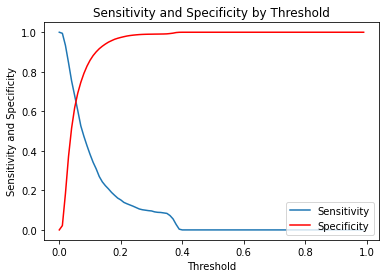

In [22]:
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, annrecall_list, label = 'Sensitivity')
plt.plot(thresh, annspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()
thresh = np.arange(0, 1, 0.01)


In [23]:

#calculate recall at 10 thresholds
lrrecall_list = []
for i in thresh:
    lrrecall_list.append(recall_score(dy_test[1], lrpreds[1][:,1] > i))
#calculate spec at 10 thresholds
lrspec_list = []
for i in thresh:
    lrspec_list.append(specificity_score(dy_test[1], lrpreds[1][:,1] > i))


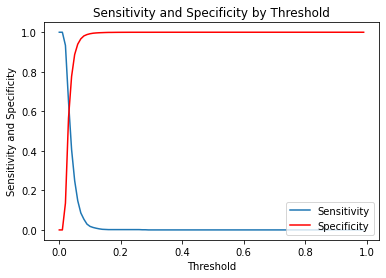

In [24]:

#plot recall vs threshold
plt.plot(thresh, lrrecall_list, label = 'Sensitivity')
plt.plot(thresh, lrspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()


In [25]:

print(recall_score(dy_test[1], lrpreds[1][:,1] > 0.028))
print(specificity_score(dy_test[1], lrpreds[1][:,1] > 0.028))


0.7089783281733746
0.5000929886553841


In [26]:

print(recall_score(dy_test[1], annpreds[1] > 0.04))
print(specificity_score(dy_test[1], annpreds[1] > 0.04))

0.7538699690402477
0.5145726507080421


In [27]:
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    

def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


IndexError: list assignment index out of range

In [34]:
#adapted from 
p = []
z = []
# Model A (random) vs. "good" model B
for x in range(1,5):
    preds_A = annpreds[x]
    preds_B = lrpreds[x][:,1]
    actual = dy_test[x]

    actual = actual.array

    def group_preds_by_label(preds, actual):
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y


    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)


    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z.append(z_score(var_A, var_B, covar_AB, auc_A, auc_B))



In [ ]:
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    

def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


IndexError: list assignment index out of range

In [ ]:
#code for Delong test adapted from https://biasedml.com/roc-comparison/
p = []
z = []
# Model A vs. Model B
for x in range(1,5):
    preds_A = annpreds[x]
    preds_B = lrpreds[x][:,1]
    actual = dy_test[x]

    actual = actual.array

    def group_preds_by_label(preds, actual):
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y


    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)


    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z.append(z_score(var_A, var_B, covar_AB, auc_A, auc_B))



In [ ]:
    
    p.append(st.norm.sf(abs(z[x-1]))*2)
    p

col_ann_tpr = []
col_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    col_ann_tpr.append(tpr)
    col_ann_fpr.append(fpr)
col_ann_tpr_array = [np.array(x) for x in col_ann_tpr]
mean_col_ann_tpr = [np.mean(k) for k in zip(*col_ann_tpr_array)]
col_ann_fpr_array = [np.array(x) for x in col_ann_fpr]
mean_col_ann_fpr = [np.mean(k) for k in zip(*col_ann_fpr_array)]
%store mean_col_ann_tpr
%store mean_col_ann_fpr


col_lr_tpr = []
col_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    col_lr_tpr.append(tpr)
    col_lr_fpr.append(fpr)
col_lr_tpr_array = [np.array(x) for x in col_lr_tpr]
mean_col_lr_tpr = [np.mean(k) for k in zip(*col_lr_tpr_array)]
col_lr_fpr_array = [np.array(x) for x in col_lr_fpr]
mean_col_lr_fpr = [np.mean(k) for k in zip(*col_lr_fpr_array)]
%store mean_col_lr_tpr
%store mean_col_lr_fpr

col_ann_rec = []
col_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    col_ann_rec.append(rec)
    col_ann_prec.append(prec)
col_ann_rec_array = [np.array(x) for x in col_ann_rec]
mean_col_ann_rec = [np.mean(k) for k in zip(*col_ann_rec_array)]
col_ann_prec_array = [np.array(x) for x in col_ann_prec]
mean_col_ann_prec = [np.mean(k) for k in zip(*col_ann_prec_array)]
%store mean_col_ann_rec
%store mean_col_ann_prec


col_lr_rec = []
col_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    col_lr_rec.append(rec)
    col_lr_prec.append(prec)
col_lr_rec_array = [np.array(x) for x in col_lr_rec]
mean_col_lr_rec = [np.mean(k) for k in zip(*col_lr_rec_array)]
col_lr_prec_array = [np.array(x) for x in col_lr_prec]
mean_col_lr_prec = [np.mean(k) for k in zip(*col_lr_prec_array)]
%store mean_col_lr_rec
%store mean_col_lr_prec
